# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [3]:
%load_ext autoreload
%autoreload 2

from dp_policy.titlei.utils import get_sppe
import pandas as pd

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [4]:
from dp_policy.titlei.utils import get_saipe

saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                             median_cv  
State FIPS Code District ID             
1               190               0.23  
                5                 0.23  
                30                0.28  
                60                0.35  
                90                0.23

In [5]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

In [6]:
from dp_policy.titlei.mechanisms import GroundTruth

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [7]:
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting

weighting(1559, 10000)

1993.0

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


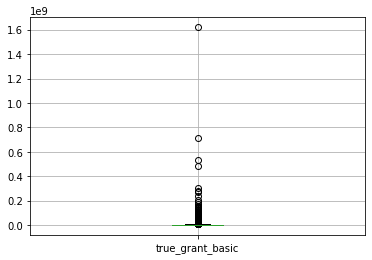

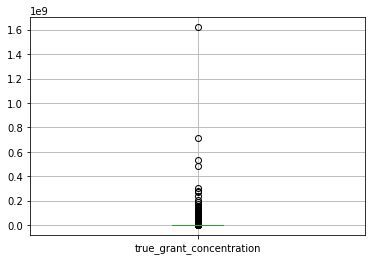

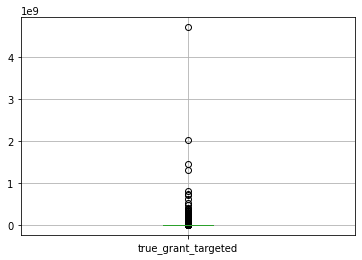

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(saipe, SonnenbergAuthorizer, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [9]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(State FIPS Code  District ID
 1                190            3.464135e+04
                  5              2.204000e+04
                  30             1.692158e+04
                  60             8.844617e+03
                  90             2.203783e+04
                                     ...     
 56               6240           7.143364e+03
                  5820           6.695801e+02
                  4830           5.457347e+03
                  6090           1.463430e+03
 72               30             3.193694e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 State FIPS Code  District ID
 1                190              6740.427037
                  5                4132.512362
                  30               2580.379487
                  60               1462.782960
                  90               3064.163872
                                     ...      
 56               6240             1292.374132
                  5820              122

### Results
First, using the full Sonnenberg authorization algo.

In [10]:
grants = funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,1.318200e+04,1.318200e+04,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,2.651938e+04,4.049290e+03,625.253224,0.383360,2.651938e+04,4.049292e+03,625.253533,625.253224,625.253533,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026313e+06,2.231893e+06,5.061881e+06
std,1.155746e+05,1.728792e+04,3467.140325,0.171494,1.155746e+05,1.728792e+04,3467.140697,3467.140325,3467.140697,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912447e+07,1.908714e+07,5.239816e+07
min,0.000000e+00,0.000000e+00,0.000000,0.150000,6.252636e-02,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.802000e+03,4.260000e+02,52.000000,0.230000,2.802245e+03,4.260032e+02,52.091485,52.000000,52.091485,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.606698e+05,0.000000e+00,1.930055e+05
50%,7.911000e+03,1.186000e+03,147.000000,0.350000,7.910962e+03,1.186080e+03,147.133939,147.000000,147.133939,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.499627e+05,0.000000e+00,7.287789e+05
75%,2.101825e+04,3.222000e+03,411.000000,0.420000,2.101826e+04,3.222121e+03,411.171856,411.000000,411.171856,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.077067e+06,9.132620e+05,2.294618e+06
max,8.336817e+06,1.193045e+06,259012.000000,0.670000,8.336817e+06,1.193045e+06,259012.043908,259012.000000,259012.043908,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619697e+09,1.619697e+09,4.714288e+09


In [61]:
import itertools

def test_params(mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0]):
    allocations = []
    print(f"{len(eps)*len(delta)} iters:")
    i = 0
    for d in delta:
        for e in eps:
            print(i, end=" ")
            i += 1
            allocations.append(funding(
                saipe, 
                SonnenbergAuthorizer, 
                mech(saipe, e, d), 
                get_sppe("../data/sppe18.xlsx"), 
                weighting, 
                verbose=False)
            )
    return pd.concat(allocations, axis=0, join="inner", keys=itertools.product(delta, eps), names=["delta", "epsilon", "id"])

def calc_total(results):
    results["true_grant_total"] = results["true_grant_basic"] + results["true_grant_concentration"] + results["true_grant_targeted"]
    results["est_grant_total"] = results["est_grant_basic"] + results["est_grant_concentration"] + results["est_grant_targeted"]
    return results

def plot_results(results, delta=False):
    results = calc_total(results)
    
    eps, allocations = list(zip(*results.groupby("epsilon")))
    
    mse = []
    
    for e, alloc in results.groupby("epsilon"):
        for grant_type in ("basic", "concentration", "targeted", "total"):
            error = alloc[f"true_grant_{grant_type}"] - alloc[f"est_grant_{grant_type}"]
            error_prop = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])\
                - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
            if (e == 2.5) or (e > 0.1 and e < 0.11):
                print(f"## {grant_type} grants ##")
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"RMSE prop eps={e}:", sum(abs(error_prop)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))
        
            if grant_type == "total":
                mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
    
    grant_type = "total"
    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        ids = alloc.index.get_level_values("id").astype('str')
        plt.scatter(ids, alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(ids, alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

test_params(Laplace, eps=[0.1, 1.0], delta=[0.0]).head()

2 iters:
0 1 

State Postal Code                                 Name  \
delta epsilon id                                                          
0.0   0.1     0                 AL       Alabaster City School District   
              1                 AL     Albertville City School District   
              2                 AL  Alexander City City School District   
              3                 AL       Andalusia City School District   
              4                 AL        Anniston City School District   

                  true_pop_total  true_children_total  true_children_poverty  \
delta epsilon id                                                               
0.0   0.1     0            34669                 6710                    649   
              1            22051                 4131                    957   
              2            16920                 2575                    703   
              3             8842                 1465                    406   
              4            22043                 3065                   1057   

                  median_cv  est_pop_total  est_children_total  \
delta epsilon id                                                 
0.0   0.1     0        0.23   34669.778587         6708.185536   
              1        0.23   22047.244941         4139.048431   
              2        0.28   16898.732768         2565.105746   
              3        0.35    8838.947113         1467.560123   
              4        0.23   22030.618583         3067.487853   

                  est_children_poverty  true_children_eligible  \
delta epsilon id                                                 
0.0   0.1     0             625.980977                     649   
              1             962.260949                     957   
              2             700.319575                     703   
              3             412.843136                     406   
              4            1098.614125                    1057   

                  est_children_eligible    sppe  true_grant_basic  \
delta epsilon id                                                    
0.0   0.1     0              625.980977  9697.0      2.705623e+06   
              1              962.260949  9697.0      3.989647e+06   
              2              700.319575  9697.0      2.930744e+06   
              3              412.843136  9697.0      1.692578e+06   
              4             1098.614125  9697.0      4.406538e+06   

                  true_grant_concentration  true_grant_targeted  \
delta epsilon id                                                  
0.0   0.1     0               0.000000e+00         2.705623e+06   
              1               3.989647e+06         5.091282e+06   
              2               2.930744e+06         4.276260e+06   
              3               1.692578e+06         2.490924e+06   
              4               4.406538e+06         7.792736e+06   

                  est_grant_basic  est_grant_concentration  est_grant_targeted  
delta epsilon id                                                                
0.0   0.1     0      2.609659e+06             0.000000e+00        2.609659e+06  
              1      4.011580e+06             4.011580e+06        5.136733e+06  
              2      2.919570e+06             2.919570e+06        4.260830e+06  
              3      1.721106e+06             1.721106e+06        2.559118e+06  
              4      4.580024e+06             4.580024e+06        8.350311e+06

In [ ]:
results = test_params(Laplace)
results.to_csv("../results/titlei_laplace.csv")

## basic grants ##
RMSE at eps=0.1098541141987558: 66235.96035337393
RMSE prop eps=0.1098541141987558: 0.015068582137438532
Total misalloc at eps=0.1098541141987558: 599376539.0502163
Total true alloc: 39894838662.272514
## concentration grants ##
RMSE at eps=0.1098541141987558: 234396.71315129916
RMSE prop eps=0.1098541141987558: 0.022772886353127846
Total misalloc at eps=0.1098541141987558: 643227928.0260313
Total true alloc: 29421416873.03583
## targeted grants ##
RMSE at eps=0.1098541141987558: 147451.16762554037
RMSE prop eps=0.1098541141987558: 0.015290179629492036
Total misalloc at eps=0.1098541141987558: 989682095.7721217
Total true alloc: 66729811774.698265
## total grants ##
RMSE at eps=0.1098541141987558: 346573.1409727091
RMSE prop eps=0.1098541141987558: 0.01676970505577308
Total misalloc at eps=0.1098541141987558: 2229938736.7165065
Total true alloc: 136046067310.00618
## basic grants ##
RMSE at eps=2.5: 4387.560688694247
RMSE prop eps=2.5: 0.000724937267083026
Total misa

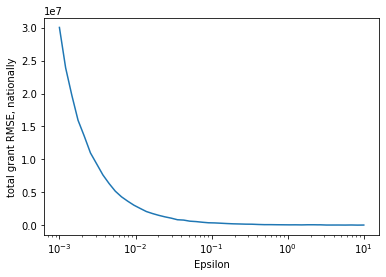

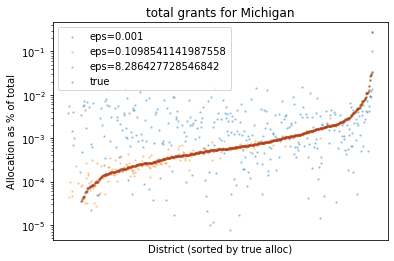

<ipython-input-11-d548260ed706>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


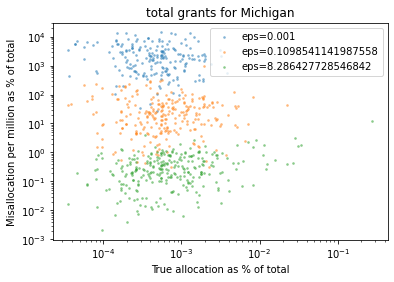

In [12]:
results = pd.read_csv("../results/titlei_laplace.csv").set_index(['delta', 'epsilon', 'id'])
plot_results(results)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [13]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [14]:
# RMSE
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

2832.7968391709787

In [15]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 26137647.773587536


In [16]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1533.3107606128242

In [17]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70036.941471052

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [43]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    Gaussian, 
    delta=list(np.linspace(0.02, 1, endpoint=False, num=10))
)
results.to_csv("../results/titlei_gaussian.csv")

510 iters:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274

In [44]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'id'])

0.216


<ipython-input-11-d548260ed706>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["true_grant_total"] = results["true_grant_basic"] + results["true_grant_concentration"] + results["true_grant_targeted"]
<ipython-input-11-d548260ed706>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["est_grant_total"] = results["est_grant_basic"] + results["est_grant_concentration"] + results["est_grant_targeted"]


## basic grants ##
RMSE at eps=0.1098541141987558: 8883.899858491466
RMSE prop eps=0.1098541141987558: 0.0020543672423645044
Total misalloc at eps=0.1098541141987558: 81835515.59154107
Total true alloc: 39894838662.272514
## concentration grants ##
RMSE at eps=0.1098541141987558: 71368.89019960957
RMSE prop eps=0.1098541141987558: 0.0030989661336924034
Total misalloc at eps=0.1098541141987558: 85467600.58049627
Total true alloc: 29421416873.03583
## targeted grants ##
RMSE at eps=0.1098541141987558: 27030.85089421071
RMSE prop eps=0.1098541141987558: 0.0019056116072240854
Total misalloc at eps=0.1098541141987558: 126872627.07142396
Total true alloc: 66729811774.698265
## total grants ##
RMSE at eps=0.1098541141987558: 80288.6085147622
RMSE prop eps=0.1098541141987558: 0.0021839189956948074
Total misalloc at eps=0.1098541141987558: 293855078.4112137
Total true alloc: 136046067310.00618
## basic grants ##
RMSE at eps=2.5: 4086.2160340285495
RMSE prop eps=2.5: 0.0007420893543783348
Total 

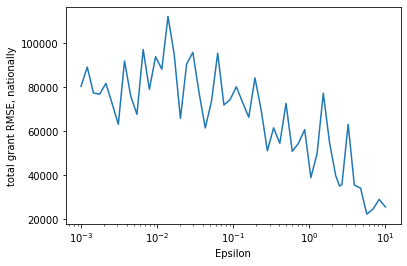

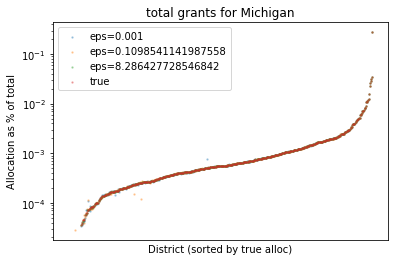

<ipython-input-11-d548260ed706>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


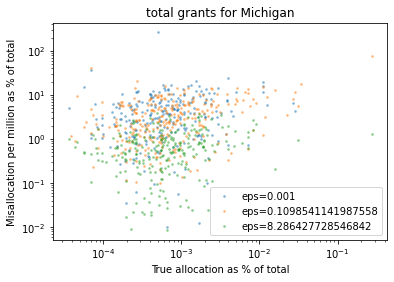

In [56]:
print(results.index.get_level_values('delta').unique()[2])
plot_results(results.xs(results.index.get_level_values('delta').unique()[2], level='delta'))

<ipython-input-11-d548260ed706>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["true_grant_total"] = results["true_grant_basic"] + results["true_grant_concentration"] + results["true_grant_targeted"]
<ipython-input-11-d548260ed706>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["est_grant_total"] = results["est_grant_basic"] + results["est_grant_concentration"] + results["est_grant_targeted"]


## basic grants ##
RMSE at eps=0.1098541141987558: 3377.3774977616863
RMSE prop eps=0.1098541141987558: 0.0005407404945223046
Total misalloc at eps=0.1098541141987558: 20978583.22247984
Total true alloc: 39894838662.272514
## concentration grants ##
RMSE at eps=0.1098541141987558: 30070.27682830566
RMSE prop eps=0.1098541141987558: 0.0007575002944599678
Total misalloc at eps=0.1098541141987558: 21275438.208985526
Total true alloc: 29421416873.03583
## targeted grants ##
RMSE at eps=0.1098541141987558: 13598.354027066682
RMSE prop eps=0.1098541141987558: 0.00048711249702892826
Total misalloc at eps=0.1098541141987558: 32209050.43305158
Total true alloc: 66729811774.698265
## total grants ##
RMSE at eps=0.1098541141987558: 33986.03635430031
RMSE prop eps=0.1098541141987558: 0.0005582405826923902
Total misalloc at eps=0.1098541141987558: 74198807.19590445
Total true alloc: 136046067310.00618
## basic grants ##
RMSE at eps=2.5: 3094.24423724078
RMSE prop eps=2.5: 0.0004094632761867137
Tota

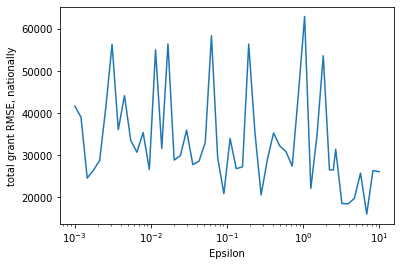

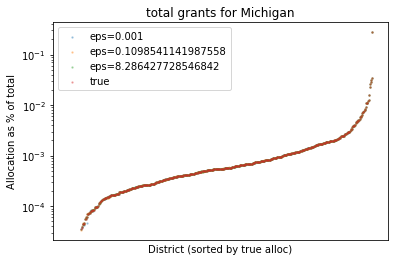

<ipython-input-11-d548260ed706>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


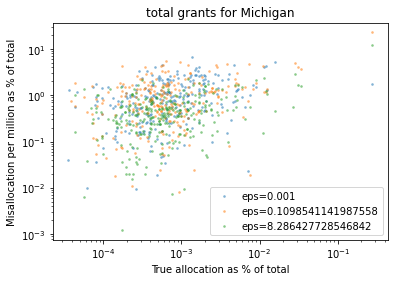

In [47]:
plot_results(results.xs(0.804))

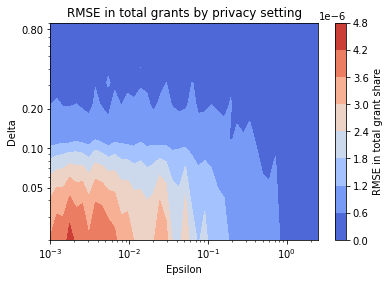

In [135]:
from matplotlib.ticker import FormatStrFormatter

results = calc_total(results)
eps = list(results.index.get_level_values("epsilon").unique())

delts = list(results.index.get_level_values("delta").unique())
mse = np.zeros((len(eps), len(delts)))
for params, alloc in results.groupby(["epsilon", "delta"]):
    
    e, d = params
    error = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]) \
        - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
    mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
    
plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([0.05, 0.1, 0.2, 0.8])
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.xlim(None, 2.5)
plt.xlabel("Epsilon")
plt.ylabel("Delta")
plt.title("RMSE in total grants by privacy setting")
plt.colorbar(label="RMSE in total grant share")
plt.show()

# Uncertainty

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

In [141]:
from dp_policy.titlei.mechanisms import Gaussian

grants_laplace = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaussian = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 2.52, 0.8), get_sppe("../data/sppe18.xlsx"), weighting))
print(grants_laplace.shape, grants_gaussian.shape)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
(13182, 20) (13182, 20)


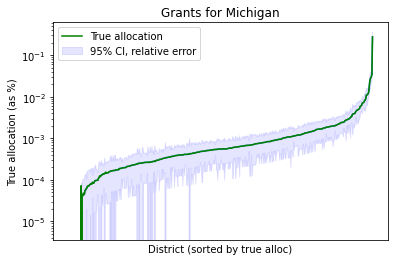

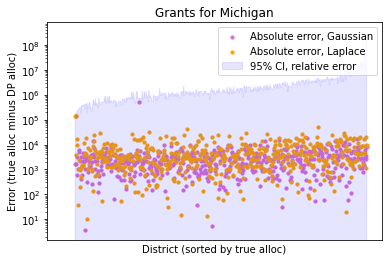

In [146]:
def plot_uncertainty(grants, grants_other=None):
    grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_grant_total")
    x = grants.index.astype('str')
    y = grants.true_grant_total / sum(grants.true_grant_total)
    plt.plot(x, y)
    ax = plt.gca()
    prop_ci = 1.96 * grants.median_cv * y
    ax.fill_between(x, (y-prop_ci), (y+prop_ci), color='b', alpha=0.1, label="95% CI, relative error")

    plt.plot(x, grants.est_grant_total / sum(grants.est_grant_total), color='green', label="True allocation")

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for Michigan")
    ax.legend()
    plt.show()
    
    if grants_other is not None:
        grants_other = grants_other[grants_other["State Postal Code"] == "MI"].sort_values("true_grant_total")
        y = np.abs(grants_other.true_grant_total - grants_other.est_grant_total)
        plt.scatter(x, y, s=10, color='orchid', label="Absolute error, Gaussian")
    y = np.abs(grants.true_grant_total - grants.est_grant_total)
    plt.scatter(x, y, s=10, color='orange', label="Absolute error, Laplace")
        
    ax = plt.gca()
    ci = 1.96 * grants.median_cv * grants.true_grant_total
    ax.fill_between(x, ci, color='b', alpha=0.1, label="95% CI, relative error")

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Error (true alloc minus DP alloc)")
    plt.title(f"Grants for Michigan")
    ax.legend()
    plt.show()

plot_uncertainty(grants_laplace, grants_gaussian)
# plot_uncertainty(grants_laplace)

# Discrimination
## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.
1. Total
2. White alone
3. Black or African American alone
4. American Indian and Alaska Native alone
5. Asian alone
6. Native Hawaiian and Other Pacific Islander alone
7. Some other race alone
8. Two or more races
9. Two or more races: including Some other race
10. Two or more races: excluding Some other race, and three or more races

In [173]:
from dp_policy.titlei.utils import get_race

race = get_race("../data/sd_race18.txt")
race.head()

,,race_1est,race_1moe,race_2est,race_2moe,race_3est,race_3moe,race_4est,race_4moe,race_5est,race_5moe,race_6est,race_6moe,race_7est,race_7moe,race_8est,race_8moe,race_9est,race_9moe,race_10est,race_10moe
State FIPS Code,District ID,,,,,,,,,,,,,,,,,,,,
27,106,5663,242,5576,235,3,4,7,6,8,8,0,12,33,19,36,20,7,7,29,18
45,690,23553,252,16552,217,6325,278,0,23,80,109,0,23,51,43,545,205,52,67,493,206
55,30,3644,247,3339,251,19,15,4,7,8,6,0,9,241,106,33,25,0,9,33,25
48,7380,846,157,813,158,6,9,15,14,0,13,0,13,12,14,0,13,0,13,0,13
6,1620,107256,1060,29011,1494,6685,804,539,224,45448,1356,510,273,20125,1181,4938,747,1923,566,3015,473


In [217]:
saipe = get_saipe("../data/saipe19.xls")
saipe = saipe.join(race, how="inner")
saipe['prop_nonwhitealone'] = 1 - saipe.race_2est / saipe.race_1est
saipe.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

<ipython-input-217-a21611815801>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saipe.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0


In [227]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 0.1, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


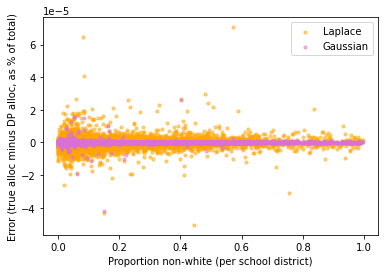

In [241]:
plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()

In [239]:
# for regression
grants["error"] = error
grants.to_csv("../results/discrimination_laplace.csv")